# Transformation visuelle pour reconstruction d'image corporelle

## Objectifs
L'objectif est d'améliorer le code de network2_01.py. 
Plusieurs pistes d'amélioration sont possibles:
1. Utiliser un produit tensoriel plutôt qu'un produit terme à terme.
2. Différencier la cible de la main.
3. Intégerer tf.
4. changer la répartition des points. 

Je m'inspire de l'article de Memisevic, Gradient-based learning of higher-order image features et de son code gatedAutoencoder.py.

## Imports et setup





In [1]:
from numpy import *
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
from drawnow import *
from skimage.draw import line, line_aa
from scipy.ndimage import gaussian_filter

import time 
import random
import scipy
import math
import cv2
import cPickle as pickle

import keras


Using TensorFlow backend.


In [2]:
matplotlib.rcParams.update({'font.size':16})
to_backup = True
timeframe = time.strftime('%Y%m%d%H%M%S')
L1 = 16
L2 = 8
L3 = 1

nb_posture = 300
nb_command = 100
nb_joint = 3
nb_data = nb_command*nb_posture
img_size = 64

## Construction de la base de données

1. On génère n postures différentes aléatoirement, X.
2. On génère m commandes aléatoirement, H. 
3. On applique chaque commande à chaque posture et on obtient des nouvelles postures Y.

### Génération des postures initiales

In [3]:
def randrange(n , vmin, vmax):
    return (vmax-vmin)*rand(n) + vmin 

In [4]:
posture = zeros((nb_posture, 3))
posture[:,0] = randrange(nb_posture, 0, pi)
posture[:,1] = randrange(nb_posture, 0, pi)
posture[:,2] =randrange(nb_posture, 0, pi)

In [5]:
print(shape(posture))
print(posture[0])

(300, 3)
[0.35016436 0.90691751 1.34759612]


### Génération des commandes 

In [6]:
command = zeros((nb_command, 3))
command[:,0] = randrange(nb_command, 0, 1)*0.3
command[:,1] = randrange(nb_command, 0, 1)*0.3
command[:,2] = 0 #randrange(nb_command, 0, 1)*0.3

In [7]:
print(shape(command))
print(command[0])
print(randint(0,nb_command-1))

(100, 3)
[0.27347536 0.21570526 0.        ]
42


### Génération des données d'entraînement

In [8]:
train_data_x = zeros((nb_data, 1, 3))
train_data_y = zeros((nb_data, 1, 3))
train_data_h = zeros((nb_data, 1, 3))

In [9]:
print(train_data_x[0][0])
print(shape(train_data_x))

[0. 0. 0.]
(30000, 1, 3)


In [10]:
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_x[idx] = posture[i]
        idx = idx + 1

idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_y[idx] = posture[i]  + command[j]
        idx = idx + 1
        
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_h[idx] = command[j]
        idx = idx + 1

In [11]:
print('train_data_x 0 0 ', train_data_x[0][0])
print('train_data_h 0 0 ', train_data_h[0][0])
print('train_data_y 0 0 ', train_data_y[0][0])
print('y = x + h')

('train_data_x 0 0 ', array([0.35016436, 0.90691751, 1.34759612]))
('train_data_h 0 0 ', array([0.27347536, 0.21570526, 0.        ]))
('train_data_y 0 0 ', array([0.62363973, 1.12262277, 1.34759612]))
y = x + h


### Génération des images associées

In [12]:
train_images_x = zeros((nb_data, 1, img_size, img_size ), dtype = float32)
train_images_y = zeros((nb_data, 1, img_size, img_size ), dtype = float32)

In [13]:
for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_x[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    #r1, c1 = line(img_size//2,img_size//2,row1, col1)
    #r2, c2 = line(row1, col1, row2, col2)
    #r3, c3 = line(row2, col2, row3 , col3)
    img[r1,c1] = val1 *255
    img[r2,c2] = val2 *255
    img[r3,c3] = val3 *255
    train_images_x[i][0] = gaussian_filter(img , sigma = 2) / 255.

for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_y[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    #r1, c1 = line(img_size//2,img_size//2,row1, col1)
    #r2, c2 = line(row1, col1, row2, col2)
    #r3, c3 = line(row2, col2, row3 , col3)
    img[r1,c1] = val1 *255
    img[r2,c2] = val2 *255
    img[r3,c3] = val3 *255
    train_images_y[i][0] =gaussian_filter(img , sigma = 2) / 255.

In [14]:
print('taille train_images_x', shape(train_images_x))
print('taille train_images_y', shape(train_images_y))
train_features = concatenate((train_images_x, train_images_y), 1)
print('taille train_features', shape(train_features))

('taille train_images_x', (30000, 1, 64, 64))
('taille train_images_y', (30000, 1, 64, 64))
('taille train_features', (30000, 2, 64, 64))


On peut rajouter une gaussienne au bout de l'effecteur pour le mettre en évidence
TODO

### Exemples d'images

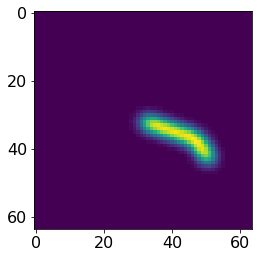

In [15]:
imshow(train_images_x[0][0])

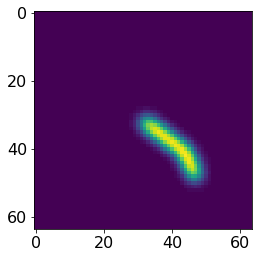

In [16]:
imshow(train_images_y[0][0])

## Factorized Gated Field Auto-encoder

Avant le passge dans l'autoencodeur, les images sont factorisées en passant par une couche de percpetron. De même, la couche latente est factorisée.
Les images sont de taille (128,128), on prend pour commencer 32 neurones. 
La sortie est de taille (3,1) (trois moteurs), on prend pour commencer une factorisation de taille (32,1) (synérgies motrices).

On a donc un encodeur, un décodeur et 3 couches de perceptrons pour les deux images et pour les commandes motrices.

On commence par construire un auto encodeur dont les entrées sont un tenseur de taille (32,1) et de sortie (32,1), pour garder la symétrie de la structure.


In [17]:
from keras.models import Model
from keras.layers import Activation, Dense, Input, Multiply
from keras.layers import Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import Dot, Lambda, Concatenate, RepeatVector
from keras import backend as K


### Création de l'encodeur 

In [18]:
input_size = 128
input_shape = (2, input_size, input_size)
latent_dim = 64 # plus facile pour la concaténation des outputs...

# on donne en entrée des pairs d'images
inputs_xy = Input(shape = (2, img_size, img_size, ), name = 'xy')

# on sépare chacune des images
x = Lambda(lambda x: x[:,0,:,:])(inputs_xy)
x = Reshape((1,img_size, img_size,))(x)

y = Lambda(lambda x: x[:,1,:,:])(inputs_xy)
y = Reshape((1,img_size, img_size,))(y)

# on factorise chacune des images
fx = Flatten()(x)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx')(fx)
fx = Reshape((latent_dim,1,))(fx)

fy = Flatten()(y)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy')(fy)
fy = Reshape((latent_dim,1,))(fy)


# on multiplie les deux factorisations, TODO mieux si produit tensoriel
matmul = Multiply()([fx, fy])

# on passe le tout dans une couche de perceptrons pour obtenir les synérgies motrices
x = Flatten()(matmul)
fh = Dense(latent_dim, name = 'latent_fh')(x)
fh = Reshape((latent_dim,))(fh)
print(K.int_shape(fh))
# on passe des synérgies motrices aux actionneurs
#latent = Dense(3, activation = 'sigmoid',  name = 'latent_vector')(fh)
#print('taille latent', K.int_shape(latent))


# tricks pour pouvoir passer fx et latent en outputs
fx = Reshape((1,latent_dim,))(fx)
fh = Reshape((1,latent_dim,))(fh)
#latent = Reshape((1,3,))(latent)

out = Concatenate()([fx, fh])
print('out taille', K.int_shape(out))

encoder = Model(inputs = inputs_xy, outputs = out, name = 'encoder')

Instructions for updating:
Colocations handled automatically by placer.
(None, 64)
('out taille', (None, 1, 128))


### Création du décodeur

In [19]:
latent_inputs = Input(shape = (1,2*latent_dim,), name = 'decoder_input')
print('taille input', K.int_shape(latent_inputs))

# on déballe la factorisation en x
fxdec = Lambda(lambda x: x[:,:,:latent_dim])(latent_inputs)
fxdec = Reshape((latent_dim,1,))(fxdec)
print('taille fx', K.int_shape(fxdec))

# on déballe les commandes motrices
inp = Lambda(lambda x: x[:,:,latent_dim:])(latent_inputs)
inp = Reshape((latent_dim,))(inp)
print('taille tmp', K.int_shape(inp))

# on fait passer les commandes motrices dans la couche de perceptrons
fhdec = Dense(latent_dim, name='latent_fhdec')(inp)
print('taille fhdec avant', K.int_shape(fhdec))
fhdec = Reshape((latent_dim,1,))(fhdec)
print('taille fhdec apres', K.int_shape(fhdec))

# on mutliplie les deux représentations
matmuldec = Multiply()([fxdec, fhdec])
print('taille matmuldec avant', K.int_shape(matmuldec))
matmuldec = Reshape((latent_dim,))(matmuldec)
print('taille matmuldec apres', K.int_shape(matmuldec))

# on en déduit une factorisation 
fydec = Dense(latent_dim, name = 'latent_fydec')(matmuldec)

# on déduit l'image de départ de cette factorisation
ydec = Dense(img_size*img_size, activation = 'relu', name = 'y_recon')(fydec)
ydec = Reshape((1,img_size, img_size,))(ydec)
print('taille img dec', K.int_shape(ydec))


decoder = Model(latent_inputs, outputs= ydec, name='decoder')

('taille input', (None, 1, 128))
('taille fx', (None, 64, 1))
('taille tmp', (None, 64))
('taille fhdec avant', (None, 64))
('taille fhdec apres', (None, 64, 1))
('taille matmuldec avant', (None, 64, 1))
('taille matmuldec apres', (None, 64))
('taille img dec', (None, 1, 64, 64))


### Création de l'auto-encodeur

In [20]:
autoencoder = Model(inputs_xy, decoder(encoder(inputs_xy)), name = "autoencoder")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xy (InputLayer)              (None, 2, 64, 64)         0         
_________________________________________________________________
encoder (Model)              (None, 1, 128)            528576    
_________________________________________________________________
decoder (Model)              (None, 1, 64, 64)         274560    
Total params: 803,136
Trainable params: 803,136
Non-trainable params: 0
_________________________________________________________________


On enregistre des figures.

In [21]:
from keras.utils import plot_model 
plot_model(encoder, to_file='encoder.png')
plot_model(decoder, to_file = 'decoder.png')
plot_model(autoencoder, to_file = 'auto_encoder.png')

### Auto-encodeur alternatif

In [22]:
input_size = 128
input_shape = (2, input_size, input_size)
latent_dim = 64 # plus facile pour la concaténation des outputs...

# on donne en entrée des pairs d'images
inputs_xy = Input(shape = (2, img_size, img_size, ), name = 'xy')

# on sépare chacune des images
x = Lambda(lambda x: x[:,0,:,:])(inputs_xy)
x = Reshape((1,img_size, img_size,))(x)

y = Lambda(lambda x: x[:,1,:,:])(inputs_xy)
y = Reshape((1,img_size, img_size,))(y)

# on factorise chacune des images avec dex conv2D
fx = Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)
fx = Flatten()(fx)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx')(fx)
fx = Reshape((latent_dim,1,))(fx)

fy = Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(y)
fy = Flatten()(fy)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy')(fy)
fy = Reshape((latent_dim,1,))(fy)

# on multiplie les deux factorisations, TODO mieux si produit tensoriel
matmul = Multiply()([fx, fy])

# on passe le tout dans une couche de perceptrons pour obtenir les synérgies motrices
x = Flatten()(matmul)
fh = Dense(latent_dim, name = 'latent_fh')(x)
fh = Reshape((latent_dim,))(fh)

# tricks pour pouvoir passer fx et latent en outputs
fx = Reshape((1,latent_dim,))(fx)
fh = Reshape((1,latent_dim,))(fh)
out = Concatenate()([fx, fh])

encoder_alt = Model(inputs = inputs_xy, outputs = out, name = 'encoder_alt')

In [23]:
latent_inputs = Input(shape = (1,2*latent_dim,), name = 'decoder_input')

# on déballe la factorisation en x
fxdec = Lambda(lambda x: x[:,:,:latent_dim])(latent_inputs)
fxdec = Reshape((latent_dim,1,))(fxdec)

# on déballe les commandes motrices
inp = Lambda(lambda x: x[:,:,latent_dim:])(latent_inputs)
inp = Reshape((latent_dim,))(inp)

# on fait passer les commandes motrices dans la couche de perceptrons
fhdec = Dense(latent_dim, name='latent_fhdec')(inp)
fhdec = Reshape((latent_dim,1,))(fhdec)

# on mutliplie les deux représentations
matmuldec = Multiply()([fxdec, fhdec])
matmuldec = Reshape((latent_dim,))(matmuldec)

# on en déduit une factorisation 
fydec = Dense(latent_dim, name = 'latent_fydec')(matmuldec)

# on déduit l'image de départ de cette factorisation
ydec = Dense(img_size*img_size, activation = 'relu', name = 'y_recon')(fydec)
ydec = Reshape((1,img_size, img_size,))(ydec)

# on rajoute une couche de déconvolution 
ydec = Conv2DTranspose(filters= 32, kernel_size = 3, activation = 'relu', padding = 'same')(ydec)
ydec = Conv2DTranspose(filters= 64, kernel_size = 3, activation = 'relu', padding = 'same')(ydec)
decoder_alt = Model(latent_inputs, outputs= ydec, name='decoder_alt')

In [24]:
autoencoder_alt = Model(inputs_xy, decoder_alt(encoder_alt(inputs_xy)), name = "autoencoder_alt")
autoencoder_alt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xy (InputLayer)              (None, 2, 64, 64)         0         
_________________________________________________________________
encoder_alt (Model)          (None, 1, 128)            172288    
_________________________________________________________________
decoder_alt (Model)          (None, 1, 64, 64)         311520    
Total params: 483,808
Trainable params: 483,808
Non-trainable params: 0
_________________________________________________________________


## Entraînement

On entraîne le modèle sur des pairs d'images.
On utilise une descente de gradient stochastique. 

In [28]:
sgd = keras.optimizers.SGD(lr = 0.01, momentum = 0.9)

autoencoder_alt.compile(loss = 'kullback_leibler_divergence', 
                    optimizer = 'sgd', 
                    metrics = ['mae', 'acc'])

history = autoencoder_alt.fit(train_features,
                          train_images_y,
                          validation_split = 0.2,
                          epochs = 1000)

Train on 24000 samples, validate on 6000 samples
Epoch 1/1000
24000/24000 [==============================] - 27s 1ms/step - loss: -0.7270 - mean_absolute_error: 124.5373 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5373 - val_acc: 0.0146
Epoch 2/1000
24000/24000 [==============================] - 26s 1ms/step - loss: -0.7270 - mean_absolute_error: 124.5395 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5471 - val_acc: 0.0146
Epoch 3/1000
24000/24000 [==============================] - 26s 1ms/step - loss: -0.7270 - mean_absolute_error: 124.5518 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5542 - val_acc: 0.0146
Epoch 4/1000
24000/24000 [==============================] - 27s 1ms/step - loss: -0.7270 - mean_absolute_error: 124.5548 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5551 - val_acc: 0.0146
Epoch 5/1000
24000/24000 [==============================] - 27s 1ms/step - loss: -0.7270 - mean_absolute_error: 124

Epoch 40/1000
24000/24000 [==============================] - 19s 810us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 41/1000
24000/24000 [==============================] - 21s 861us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 42/1000
24000/24000 [==============================] - 21s 857us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 43/1000
24000/24000 [==============================] - 21s 866us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 44/1000
24000/24000 [==============================] - 15s 604us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0

Epoch 79/1000
24000/24000 [==============================] - 20s 843us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 80/1000
24000/24000 [==============================] - 21s 858us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 81/1000
24000/24000 [==============================] - 20s 819us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 82/1000
24000/24000 [==============================] - 21s 862us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 83/1000
24000/24000 [==============================] - 20s 833us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0

24000/24000 [==============================] - 19s 789us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 118/1000
24000/24000 [==============================] - 21s 860us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 119/1000
24000/24000 [==============================] - 21s 880us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 120/1000
24000/24000 [==============================] - 18s 765us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 121/1000
24000/24000 [==============================] - 15s 621us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - va

24000/24000 [==============================] - 19s 808us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 156/1000
24000/24000 [==============================] - 20s 838us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 157/1000
24000/24000 [==============================] - 20s 835us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 158/1000
24000/24000 [==============================] - 20s 813us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 159/1000
24000/24000 [==============================] - 20s 814us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - va

24000/24000 [==============================] - 14s 574us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 194/1000
24000/24000 [==============================] - 14s 596us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 195/1000
24000/24000 [==============================] - 18s 733us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 196/1000
24000/24000 [==============================] - 21s 864us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - val_mean_absolute_error: 124.5582 - val_acc: 0.0146
Epoch 197/1000
24000/24000 [==============================] - 21s 860us/step - loss: -0.7270 - mean_absolute_error: 124.5582 - acc: 0.0151 - val_loss: -0.7594 - va

KeyboardInterrupt: 

### Visualisation

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Décodage

In [ ]:
x_decoded = autoencoder.predict(train_features)
imshow(x_decoded[0][0])

In [ ]:
imshow(train_images_y[0][0])

In [ ]:
from PIL import Image
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([train_images_x[:num], train_images_y[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, img_size, img_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, img_size, img_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs *255 ).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()


In [ ]:
shape(x_decoded[:3])